In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import sys
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
%matplotlib inline

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

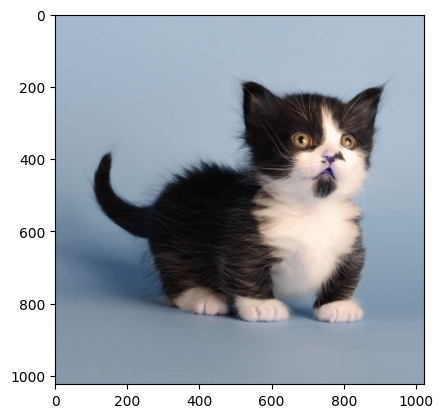

In [2]:
image = cv2.imread('./cat.jpg')
plt.imshow(image);

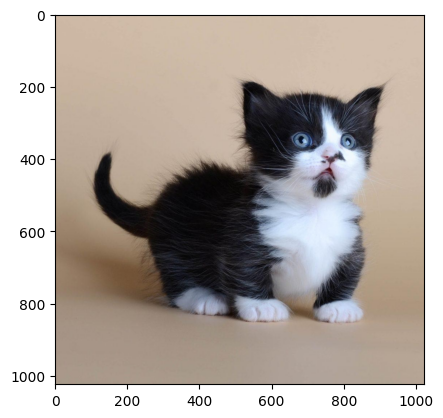

In [3]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

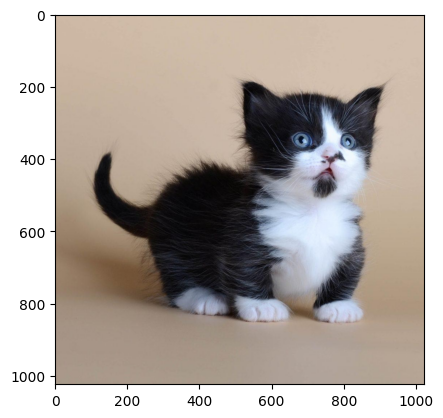

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

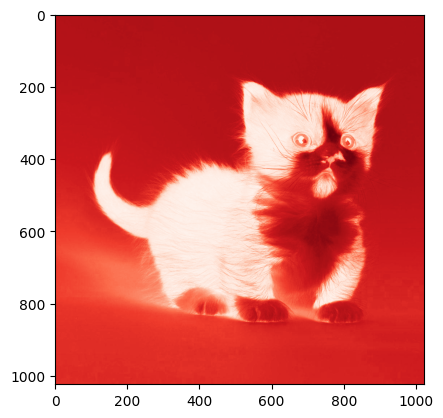

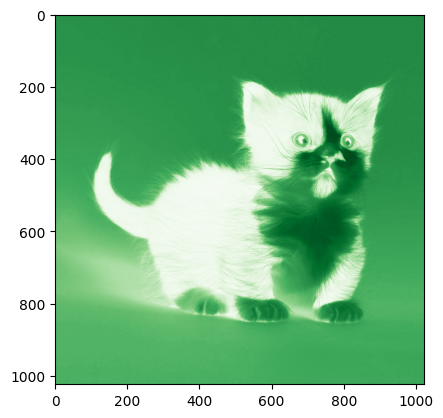

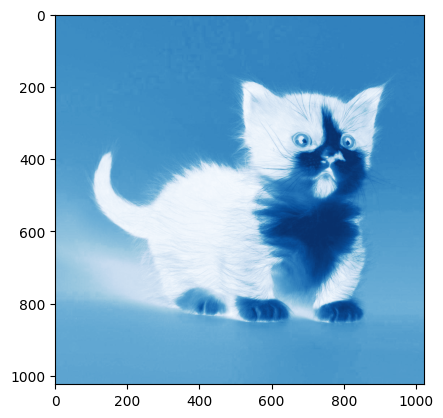

In [5]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)
![alt text](conv.png "")

In [6]:
bw_image = cv2.imread('./cat.jpg', cv2.IMREAD_GRAYSCALE)

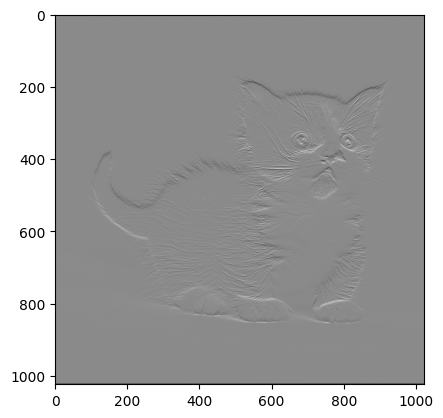

In [7]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

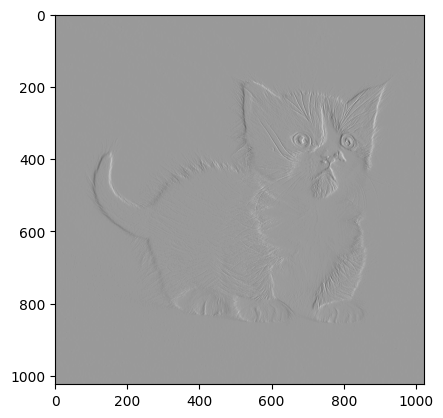

In [8]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

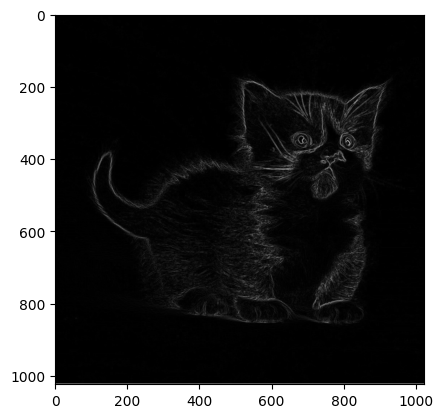

In [9]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [10]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

![alt text](pool.png "")

In [11]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):
    
    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [12]:
def max_pooling(pools: np.array) -> np.array:
    
    num_pools = pools.shape[0]
    
    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    
    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))
        
    return np.array(pooled).reshape(tgt_shape)

In [13]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [14]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm import tqdm

In [15]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [16]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

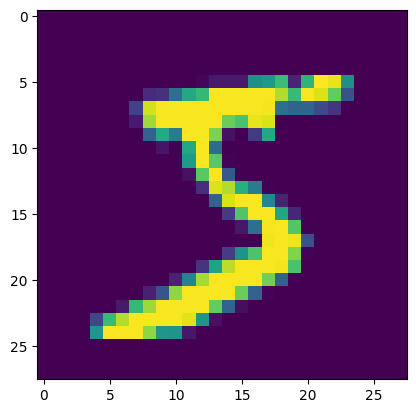

In [17]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [18]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

optimizer = torch.optim.Adam(model.parameters())

In [19]:
def train(model, optimizer, n_epochs=5, plot=True, verbose=True):
    train_loss_epochs = []
    train_accuracy_epochs = []
    val_loss_epochs = []
    val_accuracy_epochs = []
    for epoch in range(n_epochs):
        losses = []
        accuracies = []
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.mse_loss(y_pred, F.one_hot(y_train, num_classes=10).float())
            losses.append(loss.detach())
            accuracies.append((torch.argmax(y_pred, dim=-1)==y_train).numpy().mean())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))
        
        # валидация
        losses = []
        accuracies = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                losses.append(loss)
                accuracies.append((torch.argmax(y_pred, dim=-1)==y_val).numpy().mean())
        val_loss_epochs.append(np.mean(losses))
        val_accuracy_epochs.append(np.mean(accuracies))
        
        clear_output(True)
        if verbose:
            sys.stdout.write('\rEpoch {0}... (Train/Test): {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], val_loss_epochs[-1],
                        train_accuracy_epochs[-1], val_accuracy_epochs[-1]))
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(val_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(val_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()


Epoch 4... (Train/Test): 0.009/1.555	Accuracy: 0.975/0.970

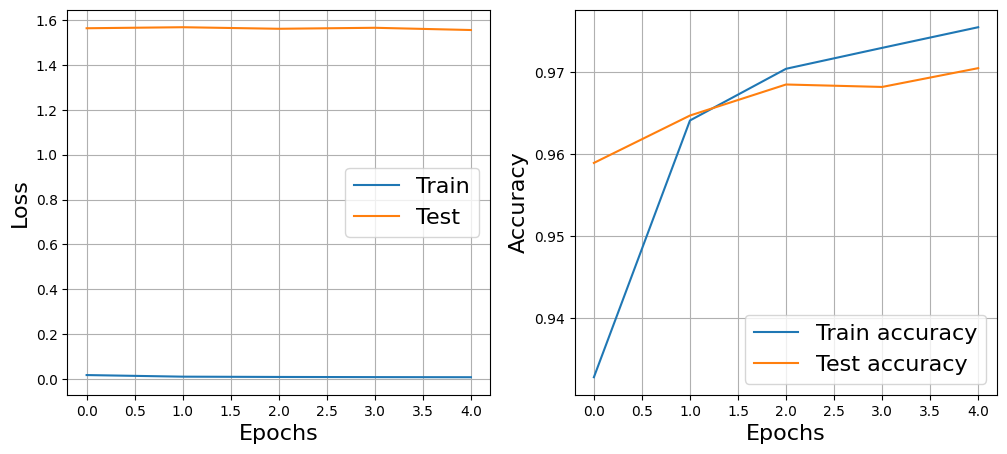

In [20]:
train(model, optimizer, n_epochs=5)

In [42]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=5, stride=3, padding=1),
    nn.Flatten(),
    nn.Linear(8*8*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(model.parameters())

### Посмотрим, сколько обучаемых параметров у модели

In [43]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=5, stride=3, padding=1, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=640, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)>

In [44]:
list(p.numel() for p in model.parameters() if p.requires_grad)

[250, 10, 81920, 128, 1280, 10]

In [45]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

83598

### Обучим модель

Epoch 9... (Train/Test): 0.004/1.501	Accuracy: 0.992/0.990

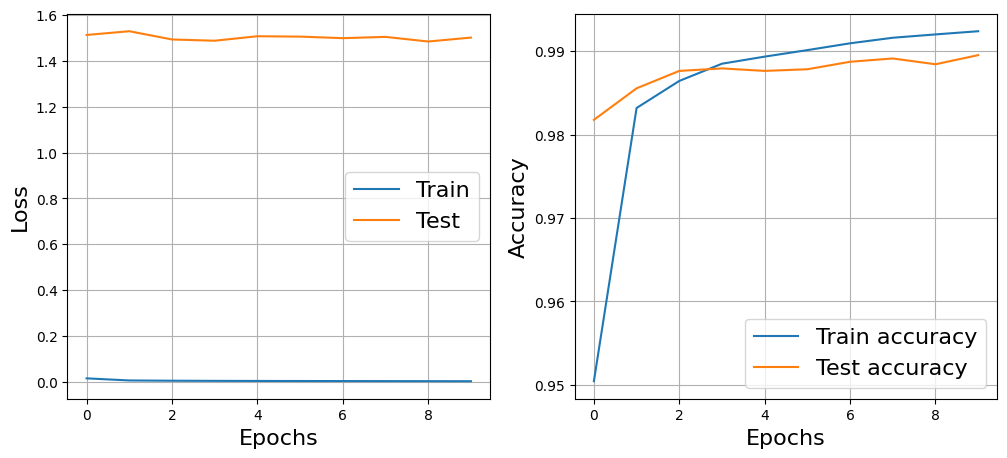

In [46]:
train(model, optimizer, n_epochs=10)

По результатам наблюдений качество не сильно меняется при варьировании параметров. Максимум удаётся достичь точности 0.99